In [ ]:
import torch
import shap
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from lime import lime_tabular
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\GRACE\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Specify the feature set
feature_set = "all_features"

# Load data
X_train = pd.read_csv(f"../Dataset/MLP Data/X_train_{feature_set}.csv")
X_val = pd.read_csv(f"../Dataset/MLP Data/X_val_{feature_set}.csv")
X_test = pd.read_csv(f"../Dataset/MLP Data/X_test_{feature_set}.csv")
y_train = pd.read_csv(f"../Dataset/MLP Data/y_train_{feature_set}.csv").squeeze()
y_val = pd.read_csv(f"../Dataset/MLP Data/y_val_{feature_set}.csv").squeeze()
y_test = pd.read_csv(f"../Dataset/MLP Data/y_test_{feature_set}.csv").squeeze()

In [3]:
X_train.columns

Index(['time', 'shunt_voltage', 'bus_voltage_V', 'current_mA', 'power_mW'], dtype='object')

In [ ]:
# Define MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_units1, hidden_units2, dropout_rate):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units1)
        self.fc2 = nn.Linear(hidden_units1, hidden_units2)
        self.dropout = nn.Dropout(dropout_rate)
        self.out = nn.Linear(hidden_units2, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.out(x)

In [8]:
model = MLP(input_size=X_train.shape[1], hidden_units1=128, hidden_units2=32, dropout_rate=0.2).to(device)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 19950/19950 [01:08<00:00, 289.75it/s]


shap_values shape: (19950, 5, 1)
shap_values shape after squeeze: (19950, 5)


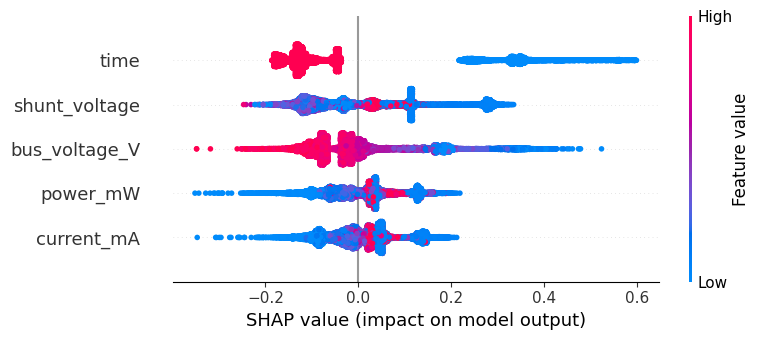

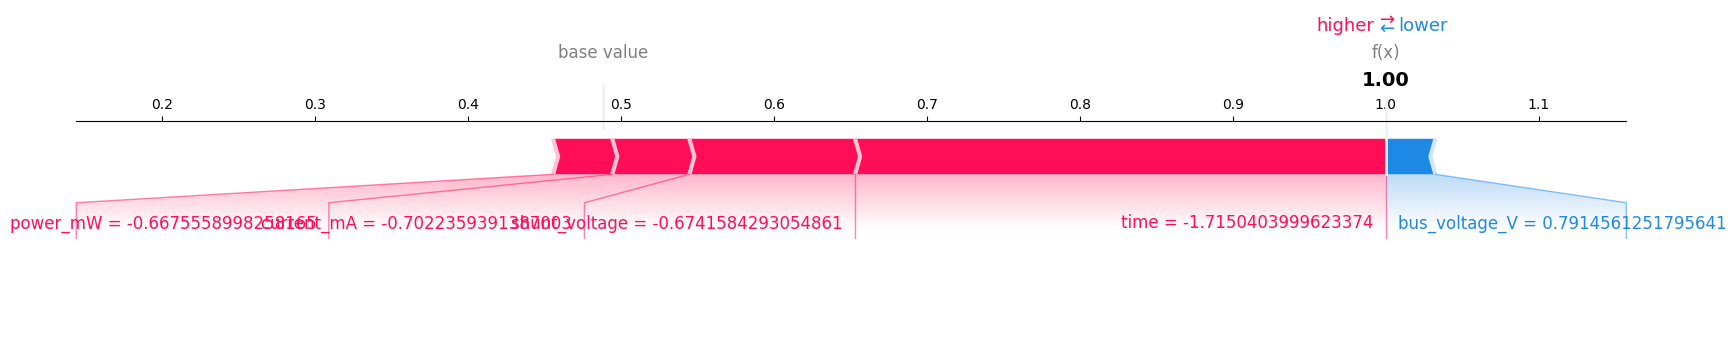

In [ ]:
model.load_state_dict(torch.load('../Model/All Features/best_mlp_model.pth'))
model.eval()

# Define the inference function for SHAP
def model_predict(X):
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32)
        output = model(X_tensor)
        return output.detach().numpy()

# Sample background data
background_data = shap.sample(X_train, 1000)

# Create explainer
explainer = shap.KernelExplainer(model_predict, background_data)
shap_values = explainer.shap_values(X_train)

# Print shape for debugging
print("shap_values shape:", shap_values.shape)
# Remove the extra dimension
shap_values = shap_values.squeeze(-1)
print("shap_values shape after squeeze:", shap_values.shape)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, show=True)

# SHAP Force Plot for a single instance
sample_index = 0
force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values[sample_index, :],
    X_train.iloc[sample_index, :],
    feature_names=X_train.columns.tolist(),
    matplotlib=True
)

## SHAP Summary Plot Interpretation

The SHAP summary analysis highlights the time feature (whether the EVSE is at nighttime: 0 or daytime: 1) as the most influential factor in the model’s predictions. The plot shows that low values of time (nighttime, shown in blue) are generally associated with positive SHAP values, pushing the prediction toward the attack class. Conversely, high values (daytime, shown in red) tend to have negative SHAP values, contributing to benign classifications. However, the SHAP values for the daytime mostly range from -0.2 to 0, indicating that while the daytime period increases the likelihood of a benign prediction, the effect is relatively modest and does not strongly drive the output probability toward 0.

This suggests that while benign behaviors appear more frequently during the daytime, time alone is not a definitive indicator of benign activity and likely interacts with other features in the model’s decision-making process. The model’s emphasis on nighttime as a significant factor aligns with real-world expectations, where attacks might be more frequent during periods of lower monitoring or activity. This insight could help in designing time-based alert systems, such as heightened monitoring during nighttime hours, to mitigate attack risks. Furthermore, the model's nuanced treatment of daytime behaviors reflects the complexity of real-world scenarios, where benign and attack patterns might overlap, requiring more than one factor for accurate differentiation.

Bus voltage (bus_voltage_V) demonstrates a mixed influence on predictions. Low bus voltage values are generally associated with attack predictions, as seen by their positive SHAP values. In contrast, higher bus voltage values show variability, contributing both positively and negatively, reflecting that this feature alone is not a consistent signal for classifying behaviors. This mixed behavior suggests that bus voltage interacts with other features in the model to provide meaningful insights, making it an essential but context-dependent feature in the decision-making process.

Shunt voltage (shunt_voltage), current (current_mA), and power (power_mW) exhibit nuanced patterns in the SHAP plot. Higher values for current and power generally push predictions toward the attack class. The presence of negative blue tails indicates a strong association between low power consumption and benign behaviors. Shunt voltage, on the other hand, shows a positive lower-value tail, suggesting that higher shunt voltage increases the likelihood of an attack classification. Although the feature displays a dense cluster of mixed samples, its high ranking (second most important) highlights its significant contribution to the classification process. Overall, we can conclude that higher shunt voltage values strongly influence the model’s predictions toward classifying an instance as an attack.

## SHAP Force Plot Interpretation

The SHAP force plot provides insights into the model's prediction for a specific instance classified as an attack (with a prediction probability close to 1). It is important to note that this force plot explains a single sample, and the results may vary when analyzing other instances. However, it still allows us to examine how the AI model learns and predicts for an individual data point, showcasing the role of XAI in understanding model behavior.

The time feature has the most significant impact, driving the prediction toward the attack class with a high negative SHAP value. This indicates that nighttime periods strongly correlate with attack behavior, aligning with real-world scenarios where attacks are more likely during periods of reduced monitoring. Additionally, the power_mW, shunt_voltage, and current_mA features significantly contribute to the prediction, highlighting that abnormal patterns in power consumption, voltage, and current are critical indicators of potential malicious activity. These features collectively push the prediction strongly toward the attack class. The bus_voltage_V feature is the only factor pulling the prediction toward the benign class, with a positive SHAP value. This shows that higher bus voltage values tend to reflect normal operations. However, its effect is relatively minor and insufficient to counterbalance the combined influence of the other features driving the prediction toward an attack.

The force plot demonstrates the model's ability to prioritize and use patterns indicative of attacks, particularly through features like time, power, and current. In a real-world context, this insight highlights the importance of continuous monitoring and anomaly detection systems that focus on these features to effectively flag potential threats. Furthermore, understanding how features reflecting benign behavior interact with attack indicators can inform model refinements to reduce false positives and enhance reliability. This showcases the value of XAI in providing transparency and actionable insights into AI-driven predictions.

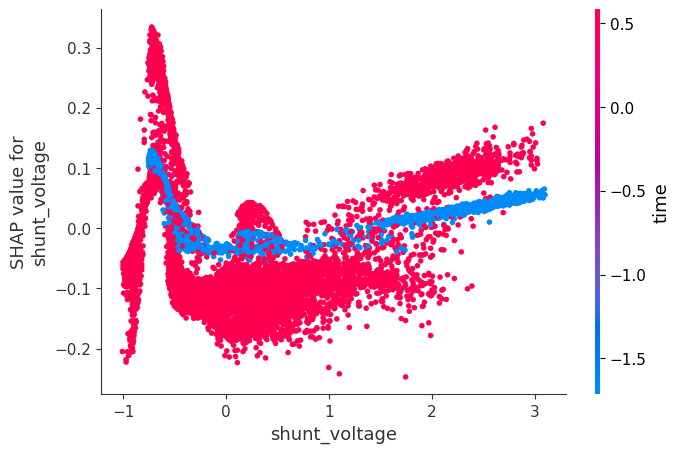

In [14]:
shap.dependence_plot("shunt_voltage", shap_values, X_train, interaction_index="time")

## SHAP Dependency Plot Interpretation

This SHAP dependency plot illustrates the relationship between the feature shunt_voltage and its corresponding SHAP values, with the color gradient representing the time feature. Positive SHAP values indicate a contribution toward predicting the "attack" class, while negative SHAP values push the prediction toward the "benign" class. For shunt_voltage values between -1 and 0, the SHAP values are predominantly positive, typically ranging from 0.0 to 0.3, suggesting that lower shunt_voltage values contribute to "attack" predictions. The high density of points in this range indicates that a significant portion of the dataset has shunt_voltage values between -1 and 0, reflecting a skewed distribution. In contrast, for shunt_voltage values between 1 and 3, the SHAP values trend downward, often falling between -0.1 and -0.2, with some points as low as -0.3, indicating that higher shunt_voltage values are more associated with the "benign" class. In the intermediate range of 0 to 1, the SHAP values fluctuate around 0, typically between -0.1 and 0.1, suggesting a more neutral impact on the model’s prediction and a weaker influence on either class.

The color gradient, representing the time feature, reveals an interaction with shunt_voltage. Points with lower time values are more concentrated in the shunt_voltage range of -1 to 0, where SHAP values are generally positive, indicating that early time points combined with low shunt_voltage are more likely to contribute to "attack" predictions. Conversely, points with higher time values are more spread out across the shunt_voltage range, particularly between 0 and 3, with SHAP values varying widely from -0.3 to 0.2. This variability suggests that at later time points, the effect of shunt_voltage on the prediction is less consistent, contributing to both "attack" and "benign" classes depending on its value. The mixing of blue and red points across the shunt_voltage range implies that time and shunt_voltage are not strongly correlated, as a strong correlation would result in a more consistent color gradient. This plot highlights the importance of shunt_voltage in distinguishing between "attack" and "benign" classes, with its impact varying across its range and being modulated by the temporal context provided by time.

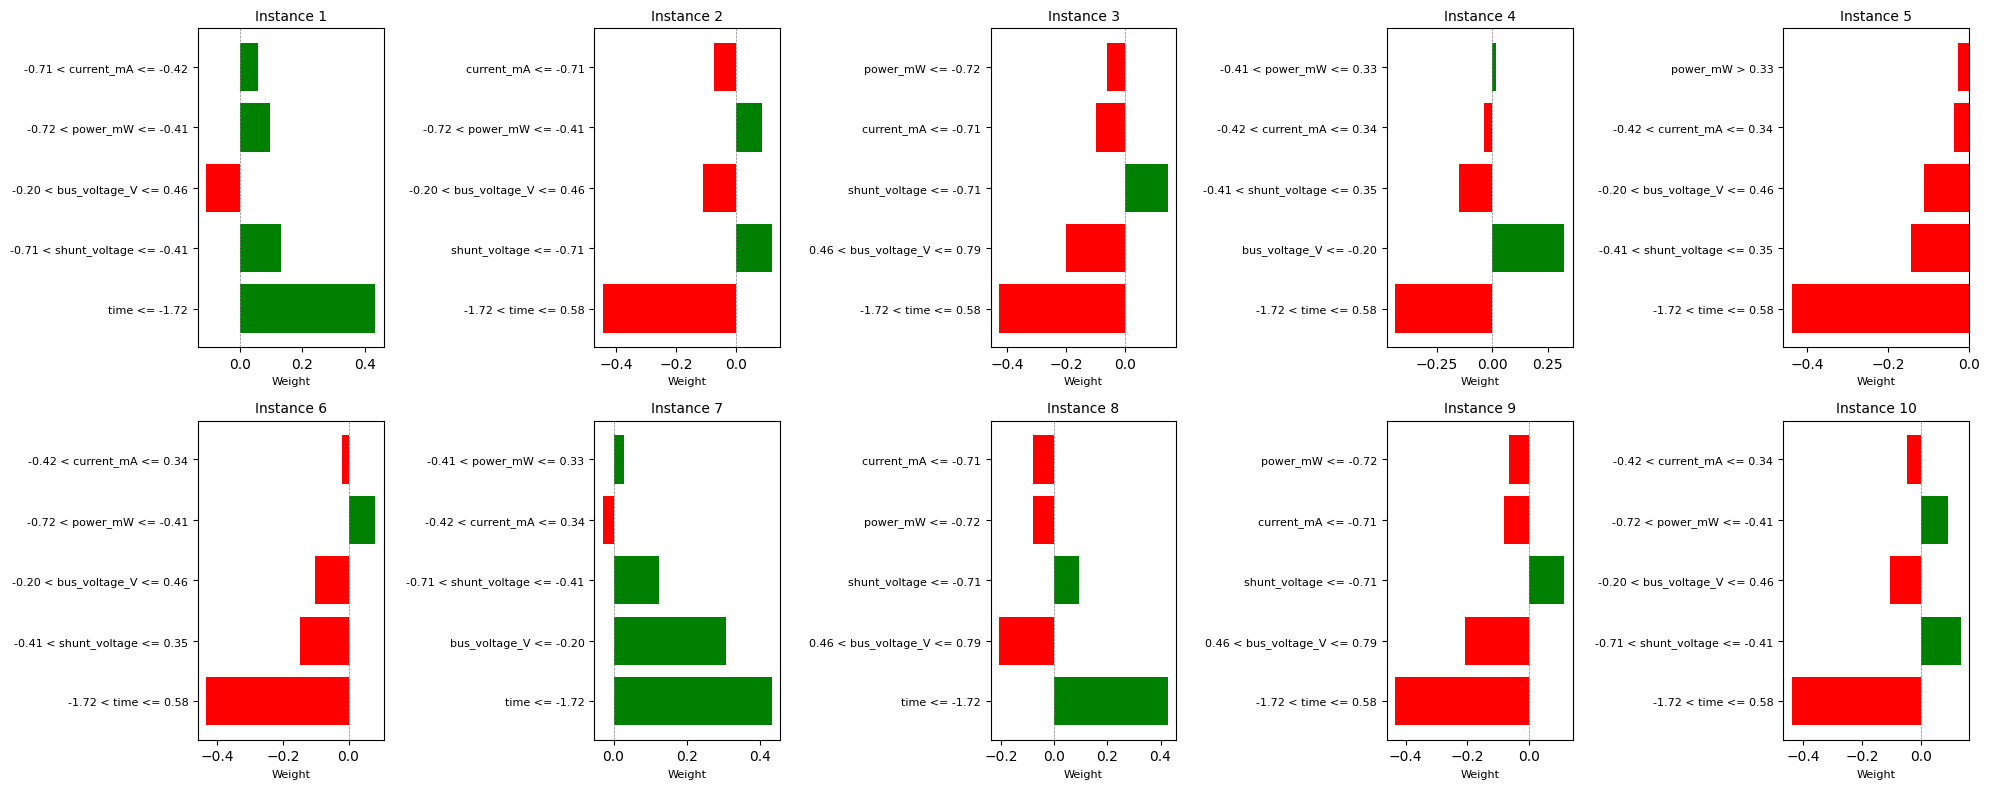

In [32]:
def predict_proba(X):
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad():
        probs = model(X_tensor).cpu().numpy()
    return np.hstack((1 - probs, probs))

# Convert X_train to NumPy for LIME
X_train_np = X_train.to_numpy()

# Initialize LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=X_train.columns.tolist(),
    class_names=["Class 0", "Class 1"],
    mode="classification"
)

# Visualize explanations for the first 10 instances in X_test
num_instances = 10
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i in range(num_instances):
    instance = X_test.iloc[i].to_numpy()
    exp = explainer.explain_instance(
        data_row=instance,
        predict_fn=predict_proba,
        num_features=5
    )
    
    # Get explanation data as a list of (feature, weight) pairs
    exp_data = exp.as_list()
    features, weights = zip(*exp_data)  # Unzip into features and weights
    colors = ['green' if w > 0 else 'red' for w in weights]
    
    # Plot on the specific subplot
    axes[i].barh(features, weights, color=colors)
    axes[i].set_title(f"Instance {i+1}", fontsize=10)
    axes[i].set_xlabel("Weight", fontsize=8)
    axes[i].tick_params(axis='y', labelsize=8)
    axes[i].axvline(0, color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## LIME Plots Interpretation

LIME provides instance-specific explanations by showing how features (time, power_mW, current_mA, shunt_voltage, and bus_voltage_V) influence the model's prediction, either pushing it toward the attack class (red bars) or the benign class (green bars). In the LIME plots for the first 10 instances, time often pushes the prediction toward the attack class, as seen in 7 out of 10 cases with red bars, but not consistently, highlighting its context-dependent role. The weight on the x-axis represents the magnitude of each feature's contribution to the prediction, with larger absolute values indicating stronger influence. The y-axis intervals display the feature value ranges, revealing patterns such as lower time values (nighttime) being more frequently linked to attack predictions, while higher bus_voltage_V values often lean toward the benign class. These intervals provide interpretable thresholds that analysts can use to identify critical feature behaviors. By combining these localized insights with SHAP’s global patterns, analysts can better understand specific anomaly triggers and refine detection mechanisms tailored to varied scenarios in EV charging infrastructure.

## Discussion

### Key Observations:

- Consistency in Feature Influence: Both LIME and SHAP highlight the critical impact of time and other features associated with abnormal power and current patterns in driving predictions toward the attack class. However, LIME explicitly separates the feature contributions for individual instances without aggregating information from other samples.

- Instance-Level Focus: The LIME plots emphasize the local interpretability of the model, focusing on how individual feature values impact a specific prediction. Unlike SHAP force plots, which visualize contributions for a single sample in a more cumulative manner, LIME generates a single sample breakdown with numerical thresholds, allowing comparisons across multiple instances.

### Algorithmic Differences:

- SHAP uses Shapley values from cooperative game theory to compute the contribution of each feature toward the model's prediction. It calculates feature importance by considering all possible feature subsets, ensuring consistency and fairness. This makes SHAP a more theoretically grounded method for feature attribution. However, it can be computationally expensive for models with a large number of features.

- LIME generates explanations by creating a surrogate linear model around the neighborhood of the specific data point being explained. It perturbs the input data by sampling in the vicinity of the original instance and evaluates the model on these perturbed inputs. LIME is faster but less comprehensive, as it approximates the decision boundary locally rather than considering all possible subsets like SHAP.

### Differences in Interpretability:

- Global vs. Local Context: SHAP provides insights into both global and local interpretability by summing Shapley values across instances to understand general feature importance. In contrast, LIME focuses solely on local interpretability, explaining individual predictions in isolation without accounting for broader trends.

- Visualization Style: SHAP force plots offer a cumulative and visually intuitive explanation of feature contributions, showing how features interact to drive a prediction. LIME presents a clearer numerical breakdown for each feature with thresholds, which may be more straightforward for instance-by-instance comparisons.